In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.core.window import Rolling
import statsmodels.api as sm 

import yfinance as yf
from yahooquery import Ticker
from yahooquery import Screener

import pmdarima

from pmdarima.arima import auto_arima
from pmdarima import model_selection, pipeline
from pmdarima import preprocessing as ppc
from pmdarima import arima
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler

from utils import *

C:\ML\kaggle\kaggle_competition\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pmdarima.__version__

'2.0.3'

In [3]:
class CFG:
    data_path = "../data"
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024

# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   

In [ ]:
nasdaq_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'nasdaq_ohlc_df.csv')
spy_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'spy_ohlc_df.csv')
dow_jones_ohlc_df = pd.read_csv(CFG.data_path + '/' + 'dow_jones_ohlc_df.csv')

In [ ]:
arima_predictions_n_errors = pd.DataFrame(
                                        data=None,
                                        index=None,
                                        columns=['1_day', '5_days', '10_days', '1_month', '2_months', '6_months', '1_year']
                                        )

arima_predictions_n_errors['Dataset'] = ['IXIC', 'IXIC', 'IXIC', 'DJI', 'DJI', 'DJI', 'SPX', 'SPX', 'SPX']
arima_predictions_n_errors['Metric'] = ['RMSE', 'MAE', 'MAPE', 'RMSE', 'MAE', 'MAPE', 'RMSE', 'MAE', 'MAPE']

arima_predictions_n_errors.set_index(['Dataset', 'Metric'], inplace=True)

In [ ]:
arima_predictions_n_errors

1_day 5_days 10_days 1_month 2_months 6_months 1_year
Dataset Metric                                                      
IXIC    RMSE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAE      NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAPE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
DJI     RMSE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAE      NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAPE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
SPX     RMSE     NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAE      NaN    NaN     NaN     NaN      NaN      NaN    NaN
        MAPE     NaN    NaN     NaN     NaN      NaN      NaN    NaN

In [22]:
START_DATE = '2017-01-01'
END_DATE = '2023-01-01'

nq = yf.download(tickers = "^IXIC",  
                    start=START_DATE, 
                    end=END_DATE)

dji = yf.download(tickers = "^DJI",  
                    start=START_DATE, 
                    end=END_DATE)

spx = yf.download(tickers = "^SPX",  
                    start=START_DATE, 
                    end=END_DATE)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [23]:
ftse = yf.download(tickers = "^FTSE",  
                    start=START_DATE, 
                    end=END_DATE)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- WIG20.WA: 1m data not available for startTime=1483225200 and endTime=1672527600. Only 7 days worth of 1m granularity data are allowed to be fetched per request.


In [35]:
nikkei = yf.download(tickers = "^N225",  
                    start=START_DATE, 
                    end=END_DATE)

[*********************100%***********************]  1 of 1 completed


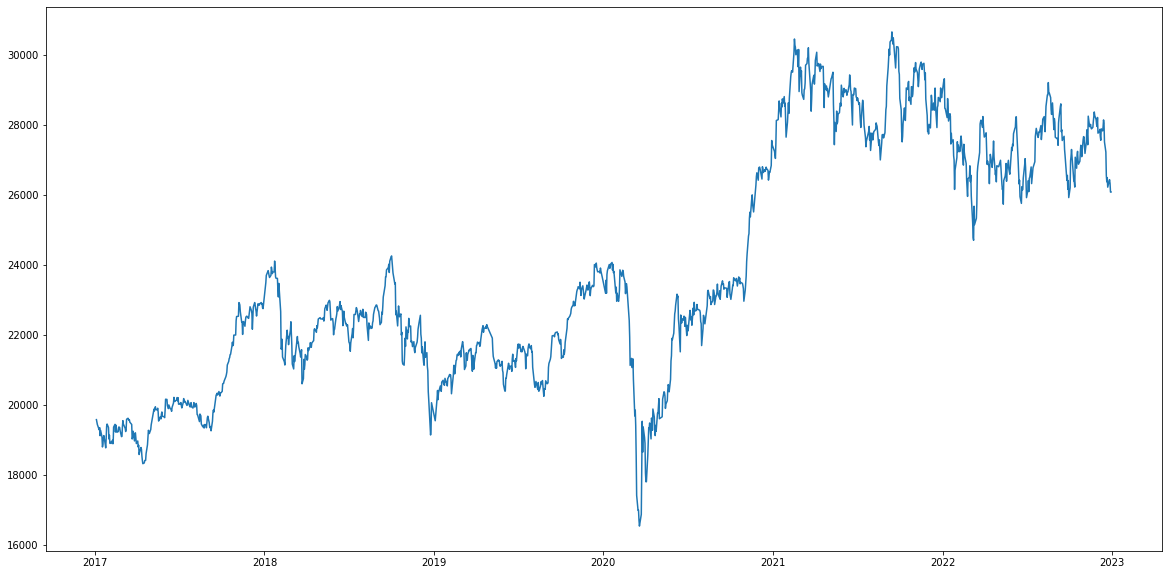

In [36]:
plt.plot(nikkei.Close, label="FTSE Close")
plt.show()

In [5]:
merged_df_dict = {
                  'Date': np.array(nq.index), 
                  'IXIC': np.array(nq.Close.values), 
                  'SPX': np.array(spx.Close.values), 
                  'DJI': np.array(dji.Close.values)
                  }

merged_df_index = nq.index

merged_df = pd.DataFrame(data=merged_df_dict, index=merged_df_index, columns=['Date', 'IXIC', 'SPX', 'DJI'])

In [7]:
len(merged_df)

1510

In [9]:
merged_df[['IXIC', 'SPX', 'DJI']].head(10)

,IXIC,SPX,DJI
Date,,,
2017-01-03,5429.080078,2257.830078,19881.759766
2017-01-04,5477.000000,2270.750000,19942.160156
2017-01-05,5487.939941,2269.000000,19899.289062
2017-01-06,5521.060059,2276.979980,19963.800781
2017-01-09,5531.819824,2268.899902,19887.380859
2017-01-10,5551.819824,2268.899902,19855.529297
2017-01-11,5563.649902,2275.320068,19954.279297
2017-01-12,5547.490234,2270.439941,19891.000000
2017-01-13,5574.120117,2274.639893,19885.730469


In [145]:
df = merged_df[['Date', 'IXIC']].copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [146]:
df

,IXIC
Date,
2017-01-03,5429.080078
2017-01-04,5477.000000
2017-01-05,5487.939941
2017-01-06,5521.060059
2017-01-09,5531.819824
...,...
2022-12-23,10497.860352
2022-12-27,10353.230469
2022-12-28,10213.290039


In [147]:
scaler = MinMaxScaler(feature_range=(1, 2))
df = scaler.fit_transform(df)

In [14]:
def ARIMA_pipeline(look_ahead, xtrain):

  y_pred = []
  print('Start')
  i = 0

  xtrain.shape = xtrain.shape[1], xtrain.shape[0], xtrain.shape[2]

  for train_slice in xtrain:
    print(f"Iteration {i}")
    fit = auto_arima(train_slice, seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4)

    arima_model = ARIMA(train_slice, order = fit.get_params().get("order")) # seasonal_order = (4,0,3,12)
    arima_result = arima_model.fit()

    arima_pred = arima_result.predict(start = 0, end = look_ahead-1, typ="levels")
    arima_pred = arima_pred[0]
    y_pred.append(arima_pred)

    i += 1
    del fit, arima_model, arima_result
    
  return y_pred

In [18]:
def arima_pipe(lookback_horizon, save_dir, model_str, arima_predictions_n_errors):

  for dataset in set(arima_predictions_n_errors.index.get_level_values(0)):

    df = merged_df[['Date', dataset]].copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    scaler = MinMaxScaler()
    df = scaler.fit_transform(df)
    
    for pred_horizon, horizon_string in [[1, '1_day'], [5, '5_days'], [10, '10_days'], [30, '1_month']]:
      
      look_back = lookback_horizon
      look_ahead = pred_horizon

      xdat, ydat = create_dataset(
                                  df,
                                  look_back = look_back,
                                  look_ahead = look_ahead
                                  )

      # [batch size, time steps, dimensionality]
      xtrain, ytrain, xvalid, yvalid = prepare_split(
                                                    xdat,
                                                    ydat,
                                                    cutoff = int(len(xdat) * 0.8),
                                                    timesteps = look_back
                                                    )
    
      y_pred = ARIMA_pipeline(look_ahead=look_ahead, xtrain=xtrain)

      plt.plot([item[0] for item in yvalid], label="True")
      # plt.plot([item.mean() for item in y_pred], label="Forecast")
      plt.plot([item[0] for item in y_pred], label="Forecast")
      plt.legend()
      plt.savefig(f"{CFG.data_path}/{save_dir}/{model_str}/{model_str}_{dataset}_{horizon_string}.jpg", bbox_inches='tight', dpi=120)
      plt.clf()
      
      arima_predictions_n_errors = assign_values(arima_predictions_n_errors,
                                                  dataset,
                                                  y_pred,
                                                  yvalid,
                                                  horizon_string)
      
  arima_predictions_n_errors.to_csv(f"{CFG.data_path}/{save_dir}/{model_str}/{model_str}_{save_dir}_window_errors.csv")

In [19]:
arima_pipe(50, '50d', 'arima', arima_predictions_n_errors)

Start
Iteration 0


Iteration 1
Iteration 2
Iteration 3
Iteration 4


C:\ML\kaggle\kaggle_competition\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 5


C:\ML\kaggle\kaggle_competition\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 6
Iteration 7
Iteration 8
Iteration 9


C:\ML\kaggle\kaggle_competition\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 10


C:\ML\kaggle\kaggle_competition\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 11


MemoryError: Unable to allocate 14.3 MiB for an array with shape (40, 40, 1168) and data type float64

: 

: 

In [ ]:
arima_predictions_n_errors

In [134]:
# xtrain.shape = xtrain.shape[1], xtrain.shape[0], xtrain.shape[2]

In [155]:
ytrain.shape

(1167, 1)

In [1]:
# look_back = 50
# look_ahead = 1

# xdat, ydat = create_dataset(df, 
#                             look_back = look_back, 
#                             look_ahead = look_ahead
#                             )

# # We only want to forecast a single value for each series => target is a column
# xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = int(len(xdat) * 0.8), timesteps = look_back)

def ARIMA_pipeline(look_ahead=1, xtrain=xtrain):

  y_pred = []
  print('Start')
  i = 0

  xtrain.shape = xtrain.shape[1], xtrain.shape[0], xtrain.shape[2]

  for train_slice in xtrain:
    # print(f"Iteration {i}")
    fit = auto_arima(train_slice, seasonal=True, m=12, max_p=7, max_d=5, max_q=7, max_P=4, max_D=4, max_Q=4)

    arima_model = ARIMA(train_slice, order = fit.get_params().get("order")) # seasonal_order = (4,0,3,12)
    arima_result = arima_model.fit()

    arima_pred = arima_result.predict(start = 0, end = look_ahead-1, typ="levels")
    arima_pred = [arima_pred[0]]
    y_pred.append(arima_pred)

    i += 1
    del fit, arima_model, arima_result

  return y_pred

NameError: name 'xtrain' is not defined

In [157]:
y_pred = ARIMA_pipeline(look_ahead)
y_pred

Start
Iteration 0
Iteration 1


C:\ML\kaggle\kaggle_competition\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 2
Iteration 3
Iteration 4
Iteration 5


C:\ML\kaggle\kaggle_competition\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 6
Iteration 7


C:\ML\kaggle\kaggle_competition\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 8
Iteration 9
Iteration 10


C:\ML\kaggle\kaggle_competition\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16


MemoryError: Unable to allocate 26.0 MiB for an array with shape (54, 54, 1168) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1014, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions.MemoryError: Unable to allocate 26.0 MiB for an array with shape (54, 54, 1168) and data type float64


: 

: 

In [152]:
y_pred[0]

0.0

In [45]:
fit = auto_arima(df['IXIC'].values, seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4)

(2, 1, 2)

In [53]:
(24 * 40 * 12) / 3600

3.2

In [47]:
# fit.summary()
fit.get_params().get("order")

(2, 1, 2)

In [76]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [74]:
len(train_data)

50

In [73]:
# train_data = df[:50]
# test_data = df[50:51]
arima_model = SARIMAX(train_data, order = fit.get_params().get("order"), seasonal_order = None) # seasonal_order = (4,0,3,12)
arima_result = arima_model.fit()
arima_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -224.726
Date:                Wed, 19 Jul 2023   AIC                            459.452
Time:                        12:19:43   BIC                            468.911
Sample:                             0   HQIC                           463.041
                                 - 50                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1839      0.155     -1.185      0.236      -0.488       0.120
ar.L2         -0.4436      0.161     -2.747      0.006      -0.760      -0.127
ma.L1          0.0703      0.231      0.305      0.761      -0.382       0.523
ma.L2          0.9980      5.550      0.180      0.857      -9.880      11.876
sigma2       511.1460   2826.787      0.181      0.857   -5029.255    6051.548
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.51   Prob(JB):                         0.73
Heteroskedasticity (H):               0.93   Skew:                            -0.05
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

C:\ML\kaggle\kaggle_competition\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


1208    15122.399289
1209    15133.102896
1210    15131.129961
1211    15131.614140
1212    15131.503638
            ...     
1505    15131.524473
1506    15131.524473
1507    15131.524473
1508    15131.524473
1509    15131.524473
Name: ARIMA Predictions, Length: 302, dtype: float64

In [41]:
test_data['IXIC'].reset_index(drop=True)

0      15121.679688
1      15215.700195
2      15090.200195
3      15226.709961
4      15235.709961
           ...     
297    10497.860352
298    10353.230469
299    10213.290039
300    10478.089844
301    10466.480469
Name: IXIC, Length: 302, dtype: float64

<AxesSubplot:>

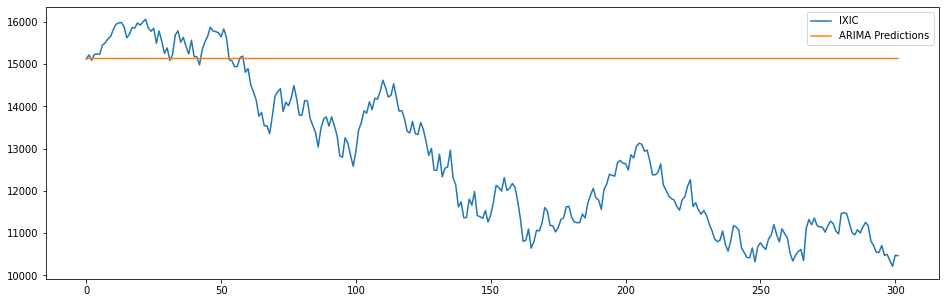

In [42]:
test_data['IXIC'].reset_index(drop=True).plot(figsize = (16,5), legend=True)
arima_pred.reset_index(drop=True).plot(legend = True)

In [23]:
nasdaq_ohlc_df = nasdaq_ohlc_df[:7050]

In [24]:
# we split the data into training and validation, leaving out the last year as holdout
xtrain, xvalid = model_selection.train_test_split(nasdaq_ohlc_df['Close'], test_size = 250)

In [27]:
# construct a pipeline, combining feature preprocessing and the model to fit
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=250)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe.fit(xtrain)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=299.59 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=82433.470, Time=19.89 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=79663.769, Time=76.71 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=85.59 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=82431.471, Time=154.10 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=78767.400, Time=108.11 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=78354.062, Time=48.81 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=78043.345, Time=54.65 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=77933.616, Time=60.90 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=283.74 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=221.94 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=77931.616, Time=57.06 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=78041.345, Time=54.29 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=226.14 sec
 ARIMA(4,2,1)(0,0,0)[0]      

Pipeline(steps=[('fourier', FourierFeaturizer(m=250)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False, trace=1))])

In [55]:
# we can inspect the results
# pipe.summary()

In [29]:
# we compute predictions from the pipeline object
preds, conf_int = pipe.predict(n_periods= xvalid.shape[0], return_conf_int=True)
print("\nForecasts:")
print(preds)


Forecasts:
6800    16496.654498
6801    16522.030408
6802    16518.646542
6803    16532.376163
6804    16565.201349
            ...     
7045    20149.776534
7046    20166.614903
7047    20159.594027
7048    20172.438136
7049    20193.407665
Length: 250, dtype: float64


<AxesSubplot:>

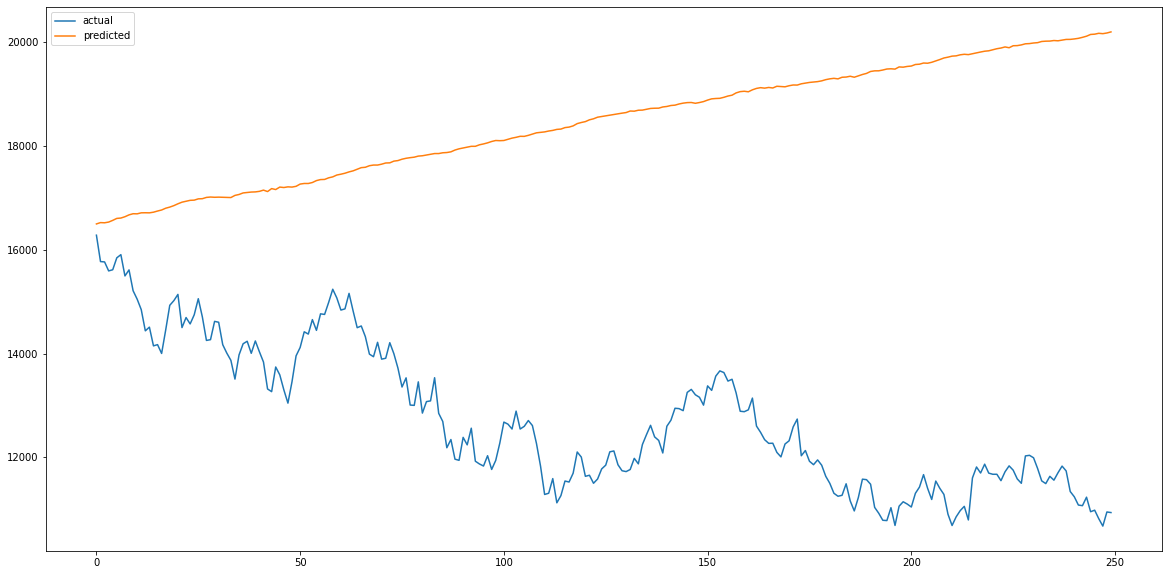

In [59]:
# let's quickly visualize the forecast
xvalid = pd.DataFrame(xvalid, columns = ['actual'])
xvalid['predicted'] = preds.reset_index(drop=True)
xvalid.plot()

In [48]:
# construct a pipeline, combining feature preprocessing and the model to fit
pipe2 = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=5)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe2.fit(xtrain)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=13.93 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=82170.292, Time=0.27 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=79391.119, Time=0.71 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.16 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=82168.293, Time=3.41 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=78508.796, Time=1.60 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=78090.908, Time=1.94 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=77779.830, Time=2.73 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=77668.149, Time=2.29 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=15.02 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=16.07 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=77666.149, Time=1.88 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=77777.830, Time=1.72 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=11.51 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf

Pipeline(steps=[('fourier', FourierFeaturizer(m=5)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False, trace=1))])

In [60]:
# we can inspect the results
pipe2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6800
Model:               SARIMAX(5, 2, 0)   Log Likelihood              -38823.075
Date:                Wed, 10 May 2023   AIC                          77666.149
Time:                        17:56:25   BIC                          77734.393
Sample:                             0   HQIC                         77689.700
                               - 6800                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
FOURIER_S5-0    -0.0347      1.064     -0.033      0.974      -2.120       2.051
FOURIER_C5-0     0.1284      1.037      0.124      0.901      -1.905       2.162
FOURIER_S5-1    -0.4357      0.706     -0.617      0.537      -1.820       0.949
FOURIER_C5-1    -1.3178      0.709     -1.860      0.063      -2.707       0.071
ar.L1           -0.9469      0.004   -224.568      0.000      -0.955      -0.939
ar.L2           -0.7108      0.006   -114.039      0.000      -0.723      -0.699
ar.L3           -0.5134      0.007    -74.959      0.000      -0.527      -0.500
ar.L4           -0.3307      0.006    -51.147      0.000      -0.343      -0.318
ar.L5           -0.1290      0.004    -30.577      0.000      -0.137      -0.121
sigma2        5348.6742     28.715    186.269      0.000    5292.394    5404.954
===================================================================================
Ljung-Box (L1) (Q):                   6.64   Jarque-Bera (JB):            132710.78
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               3.70   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
# we compute predictions from the pipeline object
preds2, conf_int2 = pipe2.predict(n_periods= xvalid.shape[0], return_conf_int=True)
print("\nForecasts:")
print(preds2)


Forecasts:
6800    16493.267910
6801    16492.369675
6802    16493.242904
6803    16496.877923
6804    16515.673972
            ...     
7045    19450.417418
7046    19461.636960
7047    19473.004790
7048    19487.458708
7049    19497.028884
Length: 250, dtype: float64


In [97]:
xvalid

,actual,predicted2,confidence lower bound,confidence upper bound
0,16279.730469,16493.267910,16349.926668,16636.609152
1,15771.780273,16492.369675,16284.204372,16700.534979
2,15765.360352,16493.242904,16214.622896,16771.862912
3,15592.190430,16496.877923,16143.657119,16850.098726
4,15614.429688,16515.673972,16080.276389,16951.071555
...,...,...,...,...
245,10985.450195,19450.417418,-69630.976464,108531.811300
246,10822.509766,19461.636960,-70158.841667,109082.115588
247,10679.339844,19473.004790,-70687.641656,109633.651236
248,10951.049805,19487.458708,-71214.436462,110189.353878


<AxesSubplot:>

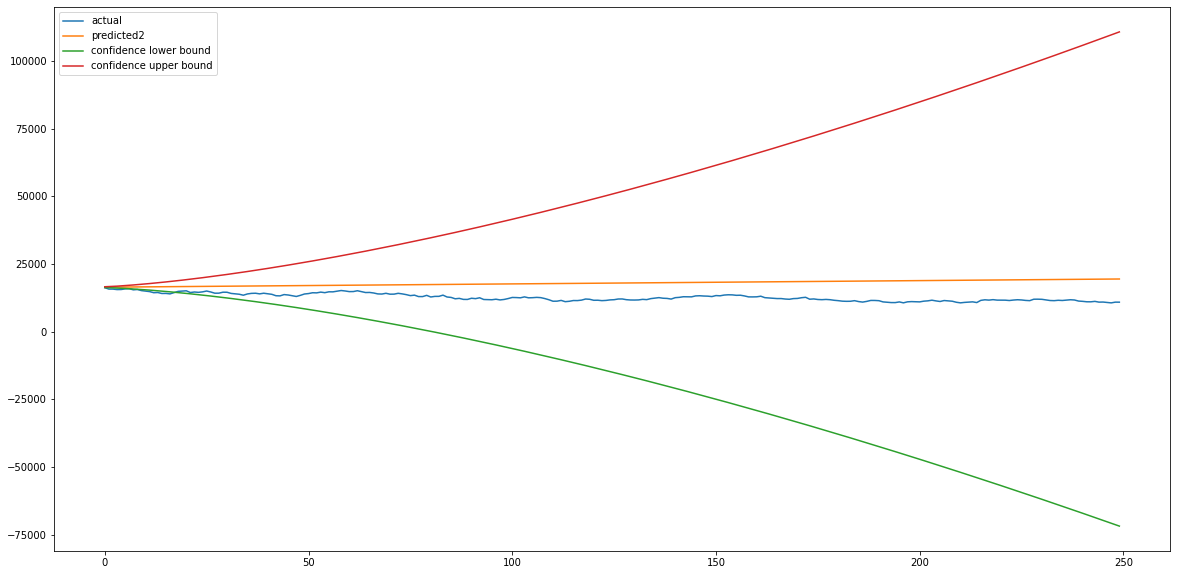

In [74]:
# let's quickly visualize the forecast
xvalid = pd.DataFrame(xvalid, columns = ['actual'])
xvalid['predicted2'] = preds2.reset_index(drop=True)
xvalid['confidence lower bound'] = conf_int2[:, :1]
xvalid['confidence upper bound'] = conf_int2[:, 1:]
xvalid.plot()

<AxesSubplot:>

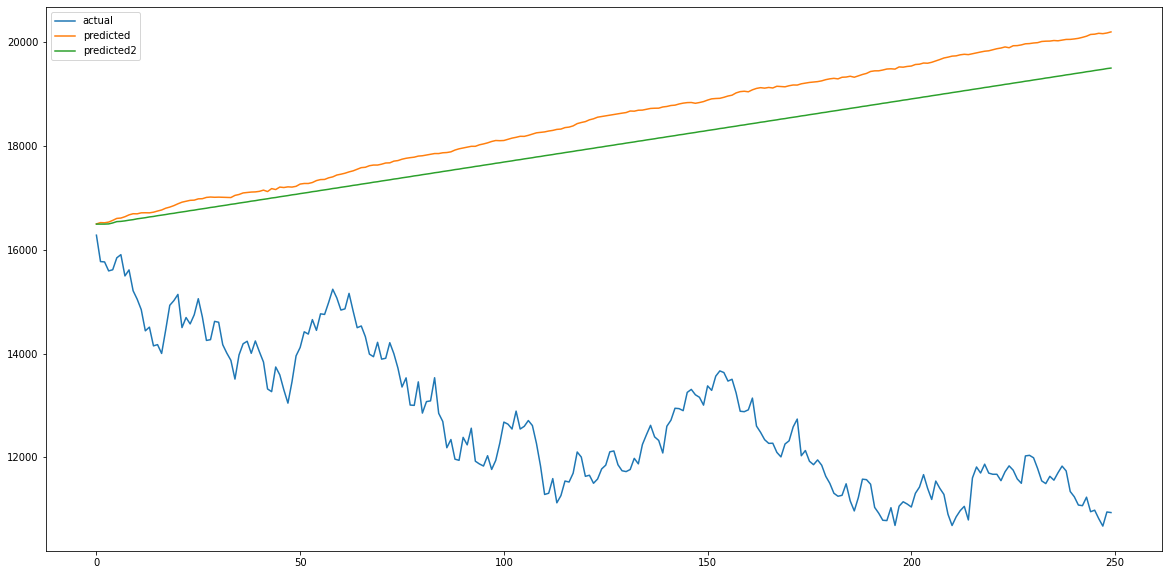

In [57]:
# let's quickly visualize the forecast
xvalid = pd.DataFrame(xvalid, columns = ['actual'])
xvalid['predicted'] = preds.reset_index(drop=True)
xvalid['predicted2'] = preds2.reset_index(drop=True)
xvalid.plot()

In [129]:
# we split the data into training and validation, leaving out the last year as holdout
xtrain2, xvalid2 = model_selection.train_test_split(nasdaq_ohlc_df['Close'], test_size = 50)

In [54]:
# construct a pipeline, combining feature preprocessing and the model to fit
pipe3 = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=5)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe3.fit(xtrain2)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=81255.843, Time=6.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=81332.497, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=81257.114, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=81259.999, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81333.013, Time=3.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=81257.840, Time=1.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=81257.901, Time=2.52 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=81255.342, Time=5.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=81253.300, Time=6.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=81253.674, Time=0.88 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=81255.941, Time=2.68 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=81257.137, Time=1.33 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=81253.930, Time=1.58 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=81103.324, Time=18.50 sec
 ARIMA(5,1,2)(0,0,

Pipeline(steps=[('fourier', FourierFeaturizer(m=5)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False, trace=1))])

In [130]:
# we compute predictions from the pipeline object
preds3, conf_int3 = pipe3.predict(n_periods= xvalid2.shape[0], return_conf_int=True)

In [131]:
xvalid2.head(), xvalid2.tail(), preds3.head(), preds3.tail()

(7000    11046.709961
 7001    11310.330078
 7002    11430.259766
 7003    11669.990234
 7004    11405.900391
 Name: Close, dtype: float64,
 7045    10985.450195
 7046    10822.509766
 7047    10679.339844
 7048    10951.049805
 7049    10939.759766
 Name: Close, dtype: float64,
 7000    11085.265966
 7001    11088.083355
 7002    11107.675510
 7003    11069.950140
 7004    11117.881220
 dtype: float64,
 7045    11100.795994
 7046    11099.772842
 7047    11098.590111
 7048    11100.964031
 7049    11099.059775
 dtype: float64)

<AxesSubplot:>

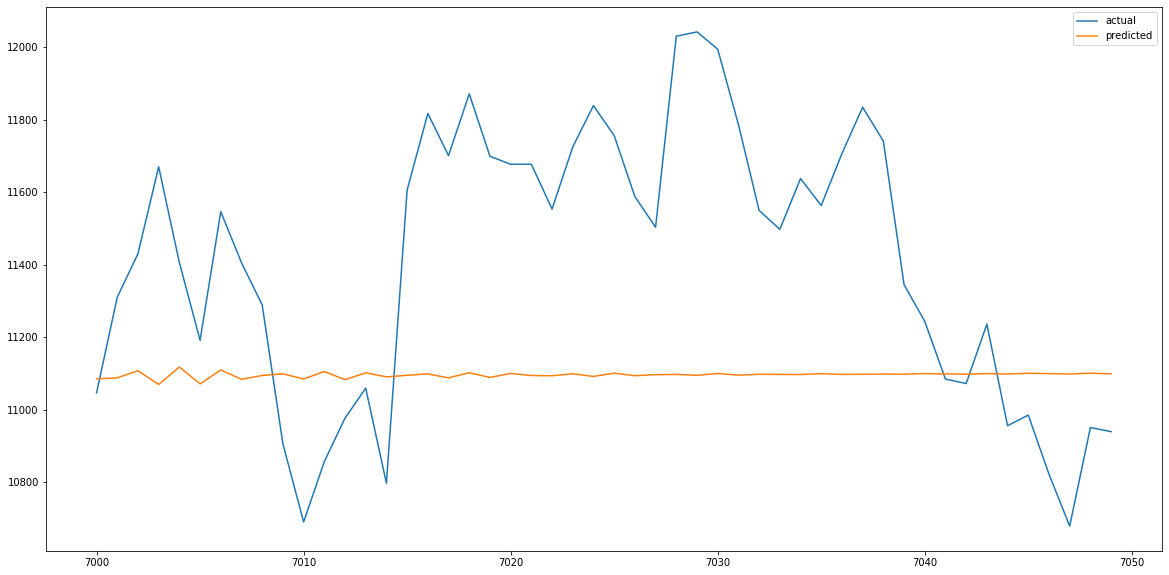

In [132]:
# let's quickly visualize the forecast
xvalid2 = pd.DataFrame(data={
    'actual' : xvalid2,
    'predicted': preds3
})
xvalid2.plot()

In [135]:
# we split the data into training and validation, we are interested in the next 5 bussines days
xtrain3, xvalid3 = model_selection.train_test_split(nasdaq_ohlc_df['Close'], test_size = 5)

In [77]:
# construct a pipeline, combining feature preprocessing and the model to fit
pipe4 = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=4)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe4.fit(xtrain3)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=82096.941, Time=7.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=82167.440, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82098.476, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=82099.959, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82167.767, Time=2.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=82100.878, Time=4.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=82101.129, Time=2.86 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=82096.637, Time=13.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=82094.638, Time=5.87 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=82095.330, Time=0.88 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=82097.143, Time=1.56 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=82099.947, Time=0.73 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=82095.050, Time=1.22 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=81948.812, Time=16.97 sec
 ARIMA(5,1,2)(0,0

Pipeline(steps=[('fourier', FourierFeaturizer(m=4)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False, trace=1))])

In [136]:
# we compute predictions from the pipeline object
preds4, conf_int4 = pipe4.predict(n_periods= xvalid3.shape[0], return_conf_int=True)

<AxesSubplot:>

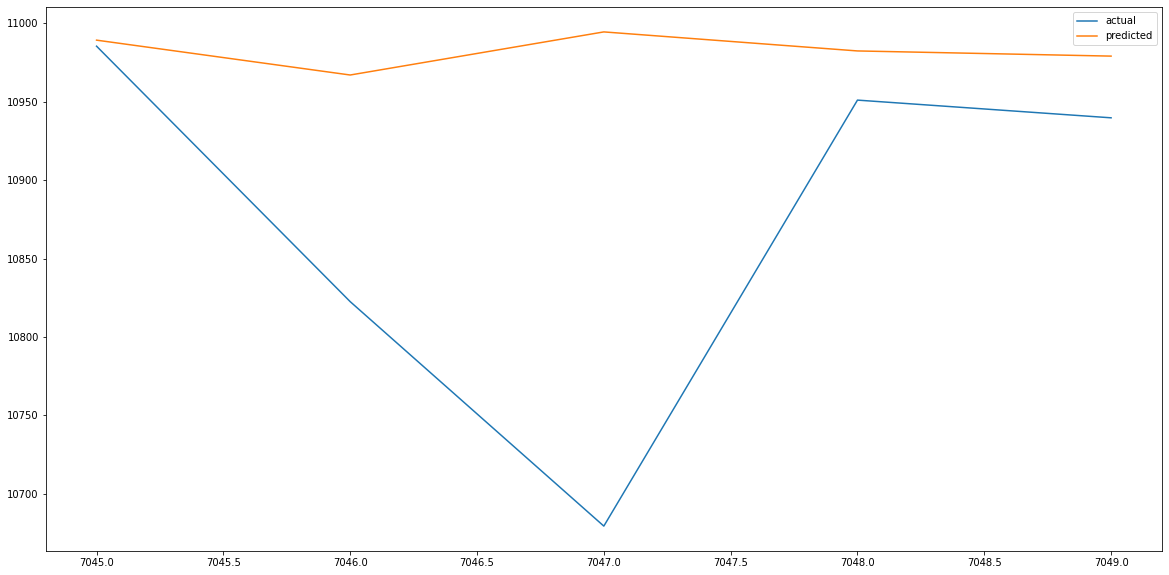

In [137]:
# let's quickly visualize the forecast
xvalid3 = pd.DataFrame(data={
    'actual' : xvalid3,
    'predicted': preds4
})
xvalid3.plot()